In [19]:
import os
import warnings

import numpy as np
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import Ridge
from matplotlib import pyplot as plt
from sklearn import config_context
from sklearn.model_selection import ValidationCurveDisplay, LearningCurveDisplay

from compare_variance_residual.simulated.simulation import generate_dataset

In [20]:
# Custom R2 scoring function (with CuPy compatibility)
def custom_r2_scorer(estimator, X, y):
    import cupy as cp
    from himalaya.scoring import r2_score

    # Ensure prediction and target arrays are fully CuPy compatible
    y_pred = estimator.predict(X)  # Prediction is likely CuPy array
    y_cp = cp.asarray(y)  # Ensure target array is also CuPy
    y_pred_cp = cp.asarray(y_pred)  # Prediction to CuPy

    # Calculate R2 score
    r2_scores = r2_score(y_cp, y_pred_cp)

    # Use CuPy mean for consistent CuPy array handling
    return float(cp.mean(r2_scores))

In [40]:
set_backend("cupy", on_error='throw')
backend = get_backend()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["SCIPY_ARRAY_API"] = "1"

feature_space_dimensions = [
    100,  # shared
    100,  # unique 0
    100,  # unique 1
]
scalars = [
    1 / 3, 1 / 3, 1 / 3
]
n_targets = 1000
n_samples_train = 10000
n_samples_test = 1000
noise_scalar = 0.1

cv = 20
alphas = np.logspace(-12, 12, 50)
param_name = "alpha"
param_range = alphas

In [22]:
(Xs_train, Xs_test, Y_train, Y_test) = generate_dataset(feature_space_dimensions, scalars, n_targets, n_samples_train,
                                                        n_samples_test, noise_scalar, construction_method="orthogonal")

Split targets into single targets, creating a 3d array with targets along the first dimension, then samples, then the single target

In [31]:
Y_trains = [backend.asarray(Y_train[:, i]).reshape(-1, 1) for i in range(n_targets)]
Y_tests = [backend.asarray(Y_train[:, i]).reshape(-1, 1) for i in range(n_targets)]
Y_trains[0].shape

(10000, 1)

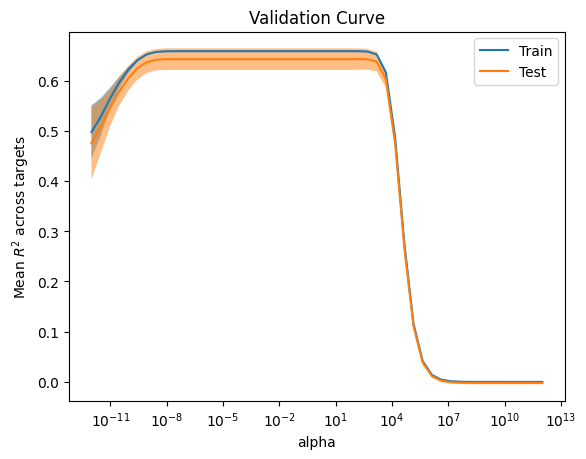

In [41]:
fig, ax = plt.subplots()
ax.set_title("Validation Curve")
with config_context(array_api_dispatch=True):
    ValidationCurveDisplay.from_estimator(
        Ridge(), Xs_train[0], Y_trains[0], param_name=param_name, param_range=param_range,
        score_name=r"Mean $R^2$ across targets", cv=cv, scoring=custom_r2_scorer, ax=ax
    )

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:2179: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 10.
  warnings.warn(


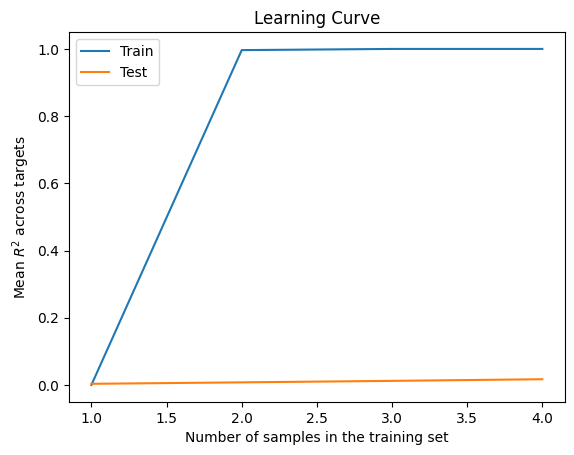

In [5]:
_, ax = plt.subplots()
ax.set_title("Learning Curve")
with config_context(array_api_dispatch=True):
    LearningCurveDisplay.from_estimator(
        Ridge(), Xs_train[0], Y_trains[0], cv=cv, scoring=custom_r2_scorer,
        train_sizes=[int(num) for num in np.logspace(0, np.log(len(Xs_train)), 10)],
        score_name=f"Mean $R^2$ across targets", ax=ax
    )